# Подготовка

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
import pandahouse
%matplotlib inline

In [106]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [107]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

# Смотрим на данные

In [108]:
# Посмотрим сколько у нас пользователей в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [109]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

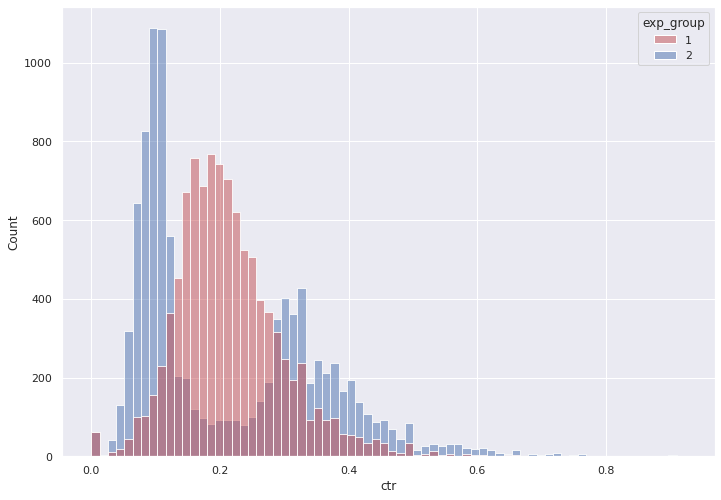

In [110]:
# Построим гистограммы распределения групп
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Можно видеть, что распределение первой (контрольной) группы похоже на нормальное, а распределение второй (экспериментальной) группы похоже на бимодальное. Визуально их средние примерно равны.

# t-тест и тест Манна-Уитни

In [116]:
#t-test

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [117]:
#Mann-Whitney test
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

t-тест показал, что разница средних двух выборок не значима, а вот тест Манна-Уитни показал, что различие между выборками статистически значимо. Это произошло как раз из-за того, что мы наблюдаем на графике: средние примерно равны, но сами распределения групп заметно отличаются между собой.

# Сглаженный CTR

In [118]:
# функция для сглаживания ctr
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

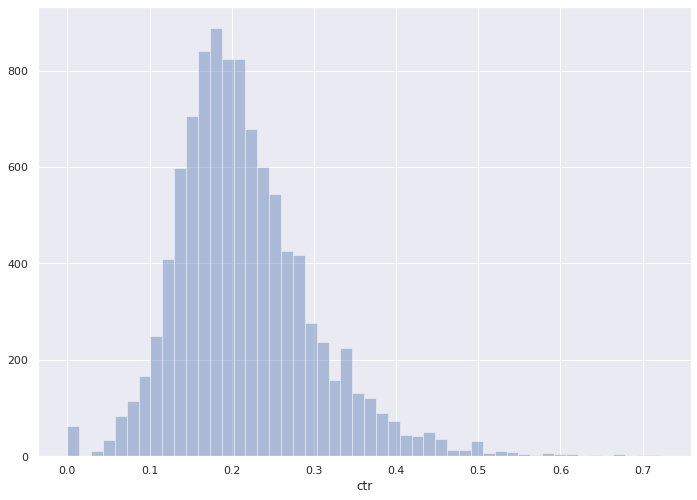

In [119]:
#считаем глобальный ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

#считаем сглаженный ctr
group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

#строим распределение обычного ctr
sns.distplot(group1.ctr, 
             kde = False)

<AxesSubplot:xlabel='smoothed_ctr'>

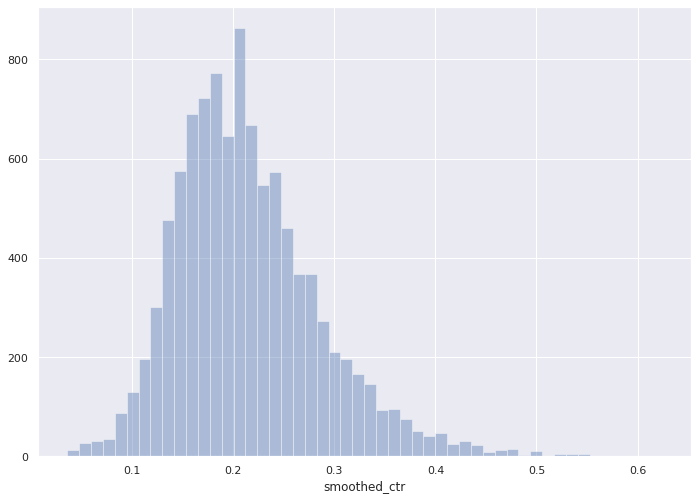

In [120]:
#строим распределение сглаженного ctr
sns.distplot(group1.smoothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr'>

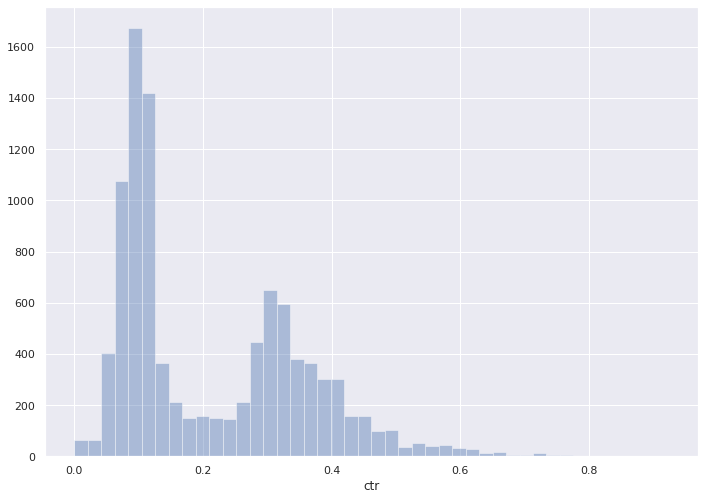

In [121]:
# то же самое для второй группы
group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smoothed_ctr'>

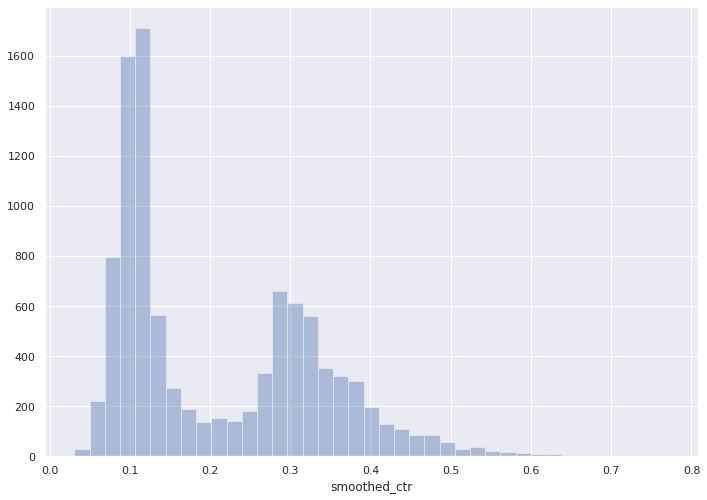

In [122]:
sns.distplot(group2.smoothed_ctr, 
             kde = False)

In [123]:
#t-тест

stats.ttest_ind(group1.smoothed_ctr,
                group2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [124]:
#Mann-Whitney test
stats.mannwhitneyu(group1.smoothed_ctr,
                   group2.smoothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

В случае со сглаженным CTR оба теста показывают, что различия между выборками значимы

# Пуассоновский бутстреп

In [125]:
# бутстреп функция для подсчета глобальных CTR
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

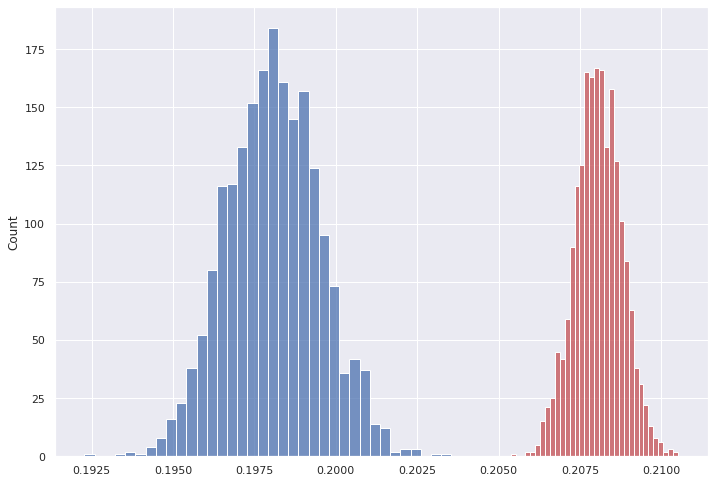

In [126]:
# считаем глобальные CTR
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

# строим распределения получившихся глобальных CTR (красным - группа 1, синим - группа 2)
sns.histplot(ctr1, color='r')
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

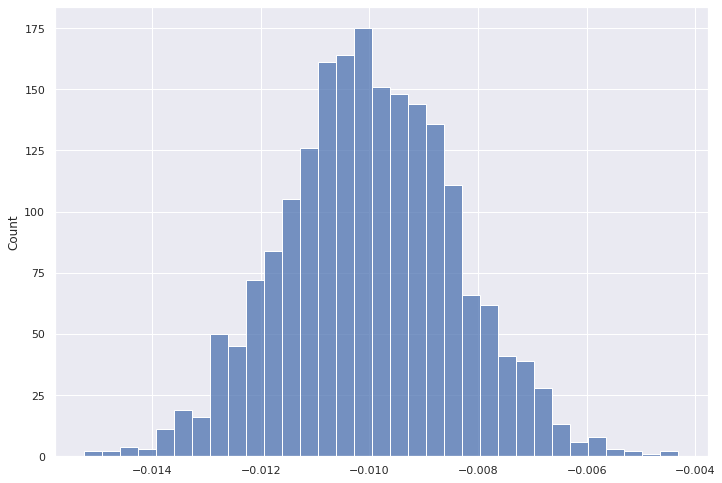

In [127]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)

<h3>По графикам можно видеть, что CTR у контрольной группы больше.</h3>

# Бакетное преобразование

In [128]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [129]:
#t-тест

stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Здесь тоже оба теста показывают, что различия между выборками значимы

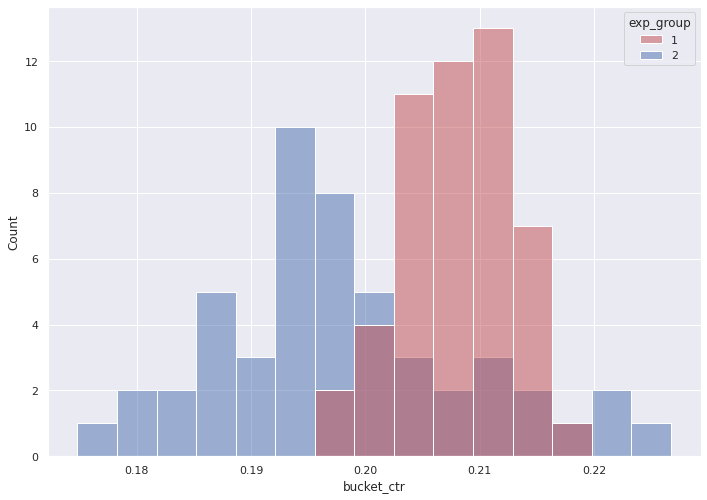

In [130]:
# Строим гистограммы
buckets = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group',
              bins=15,
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике можно видеть, что CTR первой группы в целом больше, чем CTR второй (что и подтвердилось тестами)

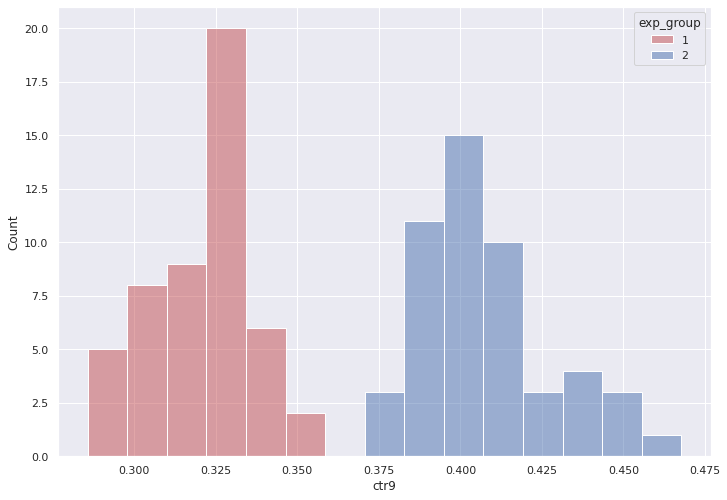

In [131]:
buckets_ctr9 = sns.histplot(data = df, 
              x='ctr9', 
              hue='exp_group',
              bins=15,
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Однако на квантиле 0.9 CTR второй группы больше. Это может быть вызвано тем, что распределение второй группы более "плоское" (хвосты распределения находятся дальше от центра), чем распределение первой группы.

# Выводы

3) Судя по гистограмме распределения CTR экспериментальной группы, можно видеть разделение значений CTR на два кластера: в большем из них CTR меньше среднего, а в меньшем CTR больше. Следовательно, в большем кластере у нас пользователи, которым предположительно "не зашел" новый алгоритм, а в меньшем - наоборот. 
Такая ситуация потенциально могла произойти, например, из-за того, что какой-то возврастной группе новая лента нравится больше старой, а другой - меньше. Может быть новый алгоритм рекомендаций предлагает больше коротких видео или наоборот почти не предлагает посты с видео.

4) Новый алгоритм не стоит раскатывать на новых пользователях, так как CTR после его внедрения понизился.